In [93]:
import librosa
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import pandas as pd
import matplotlib.pyplot as plt
import math

In [94]:
TEE_AUDIO = "D:\\Github\\Music-Rec-RAC-DataSci\\Tee cover\\Tee Sample 2.mp3"
ORG_AUDIO = "D:\\Github\\Music-Rec-RAC-DataSci\\org song\\น้อง - Three Man Down Feat. URBOYTJ _Official MV_\\vocals.mp3"

y_tee, sr_tee = librosa.load(TEE_AUDIO)
y_org, sr_org = librosa.load(ORG_AUDIO)

In [95]:
y_tee.shape[0], y_org.shape[0]

(2914128, 5206464)

In [96]:
# Manually Shift Audio
SHIFTBY = 31 + 1/30

max_shape = max(y_tee.shape[0], y_org.shape[0])
y_tee_full = np.zeros((max_shape,))
y_tee_full[round(SHIFTBY*sr_tee):round(SHIFTBY*sr_tee)+len(y_tee)] = y_tee

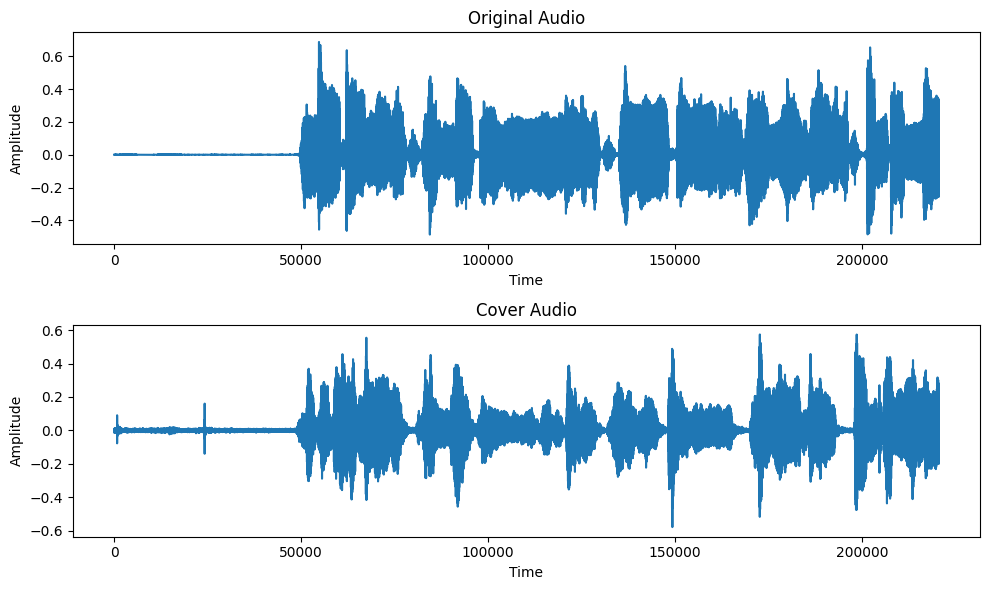

In [97]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(y_org[35*sr_org:45*sr_org])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original Audio')

plt.subplot(2, 1, 2)
plt.plot(y_tee_full[35*sr_org:45*sr_org])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cover Audio')

plt.tight_layout()
plt.show()

In [98]:
def get_onset_frames(y,sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
    return onset_frames

# tee_onset_frames = get_onset_frames(y_tee_full, sr_tee)
org_onset_frames = get_onset_frames(y_org, sr_org)

In [99]:
print(librosa.note_to_hz('E1'),",",librosa.note_to_hz('F6'))

41.20344461410875 , 1396.9129257320155


In [100]:
def get_dic(y, sr, onset_frames):
    data_dic = []

    for i, onset_frame in enumerate(onset_frames):
        start_time = librosa.frames_to_time(onset_frame, sr=sr)
        end_time = librosa.frames_to_time(onset_frames[i+1] if i+1 < len(onset_frames) else onset_frames[-1], sr=sr)
        
        # print("start_time", start_time)
        # print("end_time", end_time)
        
        dataToRead = y[int(start_time * sr) : int(end_time * sr) + 1]

        N = len(dataToRead)
        yf = rfft(dataToRead)
        xf = rfftfreq(N, 1 / sr)
        
        xf_filter = xf[(xf >= librosa.note_to_hz('E1')) & (xf <= librosa.note_to_hz('F6'))]
        if xf_filter.shape[0] != 0:
            min_idx = np.argmin(xf_filter)
            max_idx = np.argmax(xf_filter)
            
            yf_filter = yf[min_idx:max_idx+1]
            # Apply moving average to yf_filter
            #! Just on filtered value might be faster
            window = np.ones(6) / 6
            yf_filter = np.convolve(yf_filter, window, mode='same')
            
            
            #? Pick Highest Magnitude
            # idx = np.argmax(np.abs(yf_filter))
            # freq = xf_filter[idx]
            
            #? Pick Lowest Frequency of 5 highest Magnitude
            idxs = np.argpartition(yf_filter, -5)[-5:]
            freqs = xf_filter[idxs]
            min_freq_idx = freqs.argmin()
            idx = idxs[min_freq_idx]
            freq = xf_filter[idx]
            
            mag = abs(yf_filter[idx])
            if mag<0.001:
                freq=None
                mag=None
        else:
            freq=None
            mag=None
        
        # if len(data_dic) == 150:
        #     print({
        #         "start_time": start_time,
        #         "end_time": end_time,
        #         "freq": freq,
        #         "mag": mag
        #     })
        #     print("idxs", idxs)
        #     print("freqs", freqs)
        #     print("idx", idx)
        #     print(N, freq, mag)
        #     plt.figure(figsize=(15, 5))
        #     plt.plot(xf_filter, np.abs(yf_filter))
        #     plt.xlabel('Frequency (Hz)')
        #     plt.ylabel('Magnitude')
            
        #     # Calculate the percentile value
        #     percentile = np.percentile(np.abs(yf_filter), 95)
            
        #     print("std",yf_filter[yf_filter>percentile].std())
            
        #     # Plot the percentile line
        #     plt.axhline(percentile, color='r', linestyle='--', label='95th Percentile')
            
        #     plt.legend()
        #     plt.show()
        
        # freq = 0
        # while not (librosa.note_to_hz('E1') < freq < librosa.note_to_hz('F6')) and len(yf) > 0:
        #     idx = np.argmax(np.abs(yf))
        #     freq = xf[idx]
        #     yf = np.delete(yf, idx)

        # print("freq", freq, "len(yf)", len(yf))
        
        data_dic.append({
            "start_time": start_time,
            "end_time": end_time,
            "freq": freq,
            "mag": mag
        })
        
    df = pd.DataFrame(data_dic[:-1])
    # [Obsolete] df['note']=df['freq'].map(lambda x: librosa.hz_to_note(x) if x != None else None)
    # df['note']=librosa.hz_to_note(df['freq'])
    # df['note_freq']=df['note'].map(lambda x: librosa.note_to_hz(x) if x != None else None)
    return df
    
org_df = get_dic(y_org, sr_org, org_onset_frames)
tee_df = get_dic(y_tee_full, sr_tee, org_onset_frames)
org_df
tee_df

,start_time,end_time,freq,mag
0,6.478367,7.407166,NaN,NaN
1,7.407166,7.500045,NaN,NaN
2,7.500045,7.918005,NaN,NaN
3,7.918005,8.034104,NaN,NaN
4,8.034104,8.312744,NaN,NaN
...,...,...,...,...
548,206.216417,206.518277,NaN,NaN
549,206.518277,206.866576,NaN,NaN
550,206.866576,207.354195,NaN,NaN
551,207.354195,207.516735,NaN,NaN


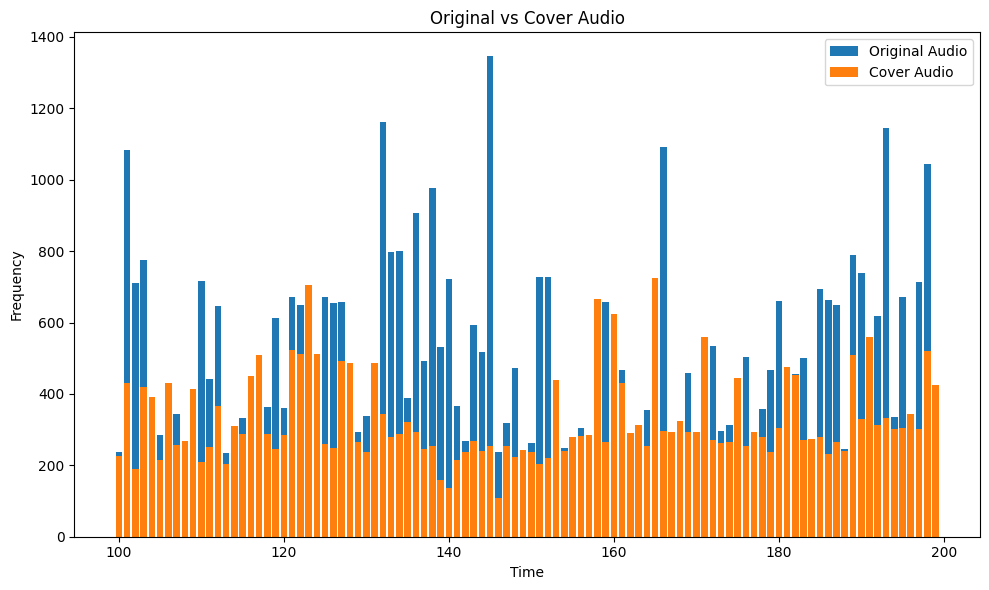

In [101]:
plt.figure(figsize=(10, 6))
plt.bar(org_df.index[100:200], org_df['freq'][100:200], label='Original Audio')
plt.bar(tee_df.index[100:200], tee_df['freq'][100:200], label='Cover Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Original vs Cover Audio')
plt.legend()
plt.tight_layout()
plt.show()

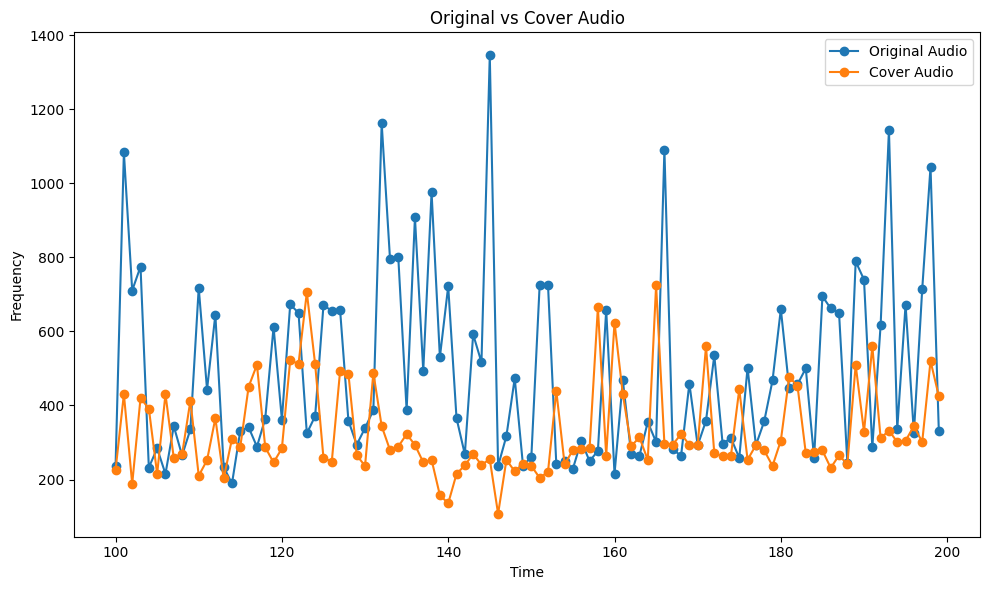

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(org_df.index[100:200], org_df['freq'][100:200], 'o-', label='Original Audio')
plt.plot(tee_df.index[100:200], tee_df['freq'][100:200], 'o-', label='Cover Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Original vs Cover Audio')
plt.legend()
plt.tight_layout()
plt.show()

In [103]:
from IPython.display import Audio

data = y_org.copy()
data2 = y_tee_full.copy()

start_frame = org_onset_frames[50]
end_frame = org_onset_frames[55]

start_time = librosa.frames_to_time(start_frame, sr=sr_org)
end_time = librosa.frames_to_time(end_frame, sr=sr_org)

start_time = 38.846984
end_time = 39.172063

start_time = 160.519546
end_time = 160.728526	

# start_frame = 5.87464853 
# end_frame = 6.22294785

# dataToRead = data[int(start_frame * sr / 1000) : int(end_frame * sr / 1000) + 1]
dataToRead = data[int(start_time * sr_org) : int(end_time * sr_org) + 1]
dataToRead2 = data2[int(start_time * sr_org) : int(end_time * sr_org) + 1]

# N = len(dataToRead)
# yf = rfft(dataToRead)
# xf = rfftfreq(N, 1 / sr)

# idx = np.argmax(np.abs(yf))
# freq = xf[idx]

In [104]:
Audio(data=dataToRead, rate=sr_org)

In [105]:
Audio(data=dataToRead2, rate=sr_org)

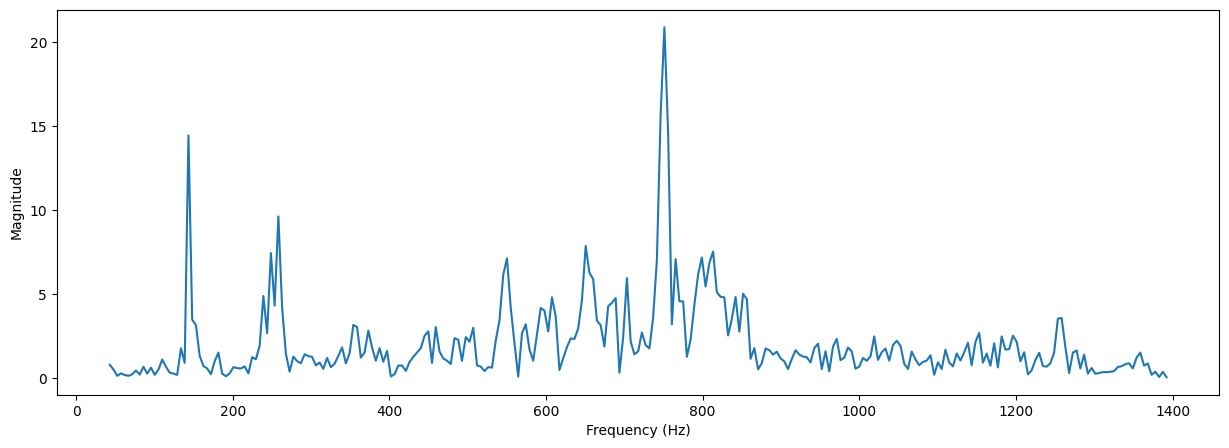

4609 751.1065307008028 20.86617068392419


In [106]:
N = len(dataToRead2)
yf = rfft(dataToRead2)
xf = rfftfreq(N, 1 / sr_org)

xf_filter = xf[(xf >= librosa.note_to_hz('E1')) & (xf <= librosa.note_to_hz('F6'))]
min_idx = np.argmin(xf_filter)
max_idx = np.argmax(xf_filter)
yf_filter = yf[min_idx:max_idx+1]

idx = np.argmax(np.abs(yf_filter))
freq = xf_filter[idx]
mag = abs(yf_filter[idx])

plt.figure(figsize=(15, 5))
plt.plot(xf_filter, np.abs(yf_filter))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

print(N, freq, mag)

In [107]:
# Base DataFrame
df_music = pd.DataFrame(columns = ["Name","Album" ,"Artist" ,"Genre","Subgenre","Publish Date","Duration","BPM","Vocal Rage","B0","C1","CS1","D1","DS1","E1","F1","FS1","G1","GS1","A1","AS1","B1","C2","CS2","D2","DS2","E2","F2","FS2","G2","GS2","A2","AS2","B2","C3","CS3","D3","DS3","E3","F3","FS3","G3","GS3","A3","AS3","B3","C4","CS4","D4","DS4","E4","F4","FS4","G4","GS4","A4","AS4","B4","C5","CS5","D5","DS5","E5","F5","FS5","G5","GS5","A5","AS5","B5","C6","CS6","D6","DS6","E6","F6","FS6","G6","GS6","A6","AS6","B6","C7","CS7","D7","DS7","E7","F7","FS7","G7","GS7","A7","AS7","B7","C8","CS8","D8","DS8"])
df_user = pd.DataFrame(columns = ["Name","ID","Love Artist","Love Genre","Love Subgenere","Age","-","Suitable BPM","Suitable Vocal Range","B0","C1","CS1","D1","DS1","E1","F1","FS1","G1","GS1","A1","AS1","B1","C2","CS2","D2","DS2","E2","F2","FS2","G2","GS2","A2","AS2","B2","C3","CS3","D3","DS3","E3","F3","FS3","G3","GS3","A3","AS3","B3","C4","CS4","D4","DS4","E4","F4","FS4","G4","GS4","A4","AS4","B4","C5","CS5","D5","DS5","E5","F5","FS5","G5","GS5","A5","AS5","B5","C6","CS6","D6","DS6","E6","F6","FS6","G6","GS6","A6","AS6","B6","C7","CS7","D7","DS7","E7","F7","FS7","G7","GS7","A7","AS7","B7","C8","CS8","D8","DS8"])

# df_music = pd.read_csv("D:\\Github\\Music-Rec-RAC-DataSci\\DB_music.csv")
# df_user = pd.read_csv("D:\\Github\\Music-Rec-RAC-DataSci\\DB_user.csv")

In [108]:
#TODO ยัดลง DB 
cache = org_df.copy()
cache['note']=librosa.hz_to_note(cache['freq'])

df = pd.DataFrame(cache['note'].value_counts().sort_index(key=lambda x: librosa.note_to_hz(x)))

df = df.transpose()
df

note,A1,D3,F♯3,G3,G♯3,A3,A♯3,B3,C4,C♯4,...,F♯5,G5,G♯5,A5,A♯5,B5,C6,C♯6,D6,E6
count,1,1,3,3,1,4,12,11,27,18,...,32,6,8,16,6,10,8,3,6,3


In [109]:
# Vocal Range / Vocal Type detection

VOCAL_RAGE = {
    'Soprano':{
        'min_note':'C4',
        'max_note':'C6',
        'gender-age': 'Female'
    },
    'Mezzo-soprano':{
        'min_note':'A3',
        'max_note':'A5',
        'gender-age': 'Female'
    },
    'Contralto':{
        'min_note':'F3',
        'max_note':'F5',
        'gender-age': 'Female'
    },
    'Countertenor':{
        'min_note':'E3',
        'max_note':'E5',
        'gender-age': 'Male'
    },
    'Tenor':{
        'min_note':'C3',
        'max_note':'C5',
        'gender-age': 'Male'
    },
    'Baritone':{
        'min_note':'A2',
        'max_note':'A4',
        'gender-age': 'Male'
    },
    'Bass':{
        'min_note':'E2',
        'max_note':'E4',
        'gender-age': 'Male'
    },
    'Treble':{
        'min_note':'A3',
        'max_note':'A5',
        'gender-age': 'Child'
    }
}

VOCAL_RAGE_DF = pd.DataFrame(VOCAL_RAGE).transpose()

VOCAL_RAGE_DF['min_freq']=librosa.note_to_hz(VOCAL_RAGE_DF['min_note'])
VOCAL_RAGE_DF['max_freq']=librosa.note_to_hz(VOCAL_RAGE_DF['max_note'])

def get_vocal_range(input_df):
    df = input_df.copy()
    df = df.dropna()
    VOCAL_RAGE_DF_cache = VOCAL_RAGE_DF.copy()

    # Find the minimum and maximum pitch values
    min_pitch = min(df['freq'])
    max_pitch = max(df['freq'])
        
    # Find the closest vocal range
    VOCAL_RAGE_DF_cache['min_diff']=(VOCAL_RAGE_DF['min_freq']-min_pitch)
    VOCAL_RAGE_DF_cache['max_diff']=(VOCAL_RAGE_DF['max_freq']-max_pitch)
    
    print(min_pitch, max_pitch)
    print(VOCAL_RAGE_DF_cache)
    print(abs(VOCAL_RAGE_DF_cache['min_diff']).idxmin())
    print(abs(VOCAL_RAGE_DF_cache['max_diff']).idxmin())
    



In [110]:
# cache = tee_df.copy()
# cache = cache.dropna()
# cache['note']=cache['freq'].map(lambda x: librosa.hz_to_note(x) if x > 0 else None)
# cache[cache['freq']>600]

In [111]:
cache = tee_df.copy()
cache['note']=cache['freq'].map(lambda x: librosa.hz_to_note(x) if x > 0 else None)

df = pd.DataFrame(cache['note'].value_counts().sort_index(key=lambda x: librosa.note_to_hz(x)))
# df['count'] = df['count'].map(lambda x: 1 if x > 0 else 0)

# print(cache['note'].unique())

vocal_range = get_vocal_range(cache)

# df.index = df.index + '_binary'

df = df.transpose()

df['Name'] = 'วังวน'

df_music = pd.concat([df_music, df], ignore_index=True, sort=False)

df

107.5609756097561 1360.558439555921
              min_note max_note gender-age    min_freq     max_freq  \
Soprano             C4       C6     Female  261.625565  1046.502261   
Mezzo-soprano       A3       A5     Female  220.000000   880.000000   
Contralto           F3       F5     Female  174.614116   698.456463   
Countertenor        E3       E5       Male  164.813778   659.255114   
Tenor               C3       C5       Male  130.812783   523.251131   
Baritone            A2       A4       Male  110.000000   440.000000   
Bass                E2       E4       Male   82.406889   329.627557   
Treble              A3       A5      Child  220.000000   880.000000   

                 min_diff     max_diff  
Soprano        154.064590  -314.056178  
Mezzo-soprano  112.439024  -480.558440  
Contralto       67.053140  -662.101977  
Countertenor    57.252803  -701.303326  
Tenor           23.251807  -837.307309  
Baritone         2.439024  -920.558440  
Bass           -25.154086 -1030.93088

note,A2,A♯2,C3,C♯3,D3,D♯3,E3,F3,F♯3,G3,...,E5,F5,F♯5,G5,G♯5,A5,A♯5,E6,F6,Name
count,1,2,2,2,1,5,1,3,4,3,...,9,7,7,7,4,2,3,1,1,วังวน


In [117]:
cache = org_df.copy()
cache.sort_values(by='freq')
cache['usr_freq'] = tee_df['freq']
cache['note_freq']=librosa.note_to_hz(librosa.hz_to_note(cache['freq']))
cache['diff_log2'] = 1+(abs(cache['freq'].map(lambda x: math.log2(x)) - cache['usr_freq'].map(lambda x: math.log2(x))))*12
cache['score'] = 1/cache['diff_log2']

cache['score'].describe()
cache[cache['score']>0.1]

,start_time,end_time,freq,mag,usr_freq,note_freq,diff_log2,score
25,37.848526,38.220045,659.373856,43.999293,470.981326,659.255114,6.825122,0.146518
29,38.846984,39.172063,270.665365,20.289442,289.119821,277.182631,2.141887,0.466878
32,39.752562,40.495601,301.446445,93.235977,257.036924,293.664768,3.759113,0.266020
34,40.658141,40.983220,338.331706,22.151323,289.119821,329.627557,3.721250,0.268727
36,41.168980,41.401179,314.323374,33.091735,310.017575,311.126984,1.238795,0.807236
...,...,...,...,...,...,...,...,...
428,157.524172,158.360091,574.156450,24.488868,629.179776,587.329536,2.584341,0.386946
431,160.148027,160.194467,150.585366,0.632574,215.121951,146.832384,7.174878,0.139375
434,160.519546,160.728526,574.094164,17.209266,846.788891,587.329536,7.728579,0.129390
436,161.076825,161.819864,663.491821,47.708230,445.468140,659.255114,7.897077,0.126629


In [113]:
cache = org_df.copy()
cache['note']=cache['freq'].map(lambda x: librosa.hz_to_note(x) if x > 0 else None)

df = pd.DataFrame(cache['note'].value_counts().sort_index(key=lambda x: librosa.note_to_hz(x)))
# df['count'] = df['count'].map(lambda x: 1 if x > 0 else 0)

# print(cache['note'].unique())

# vocal_range = get_vocal_range(cache)

# df.index = df.index + '_binary'

df = df.transpose()


df['Name'] = 'Tee'

df_user = pd.concat([df_user, df], ignore_index=True, sort=False)

df

note,A1,D3,F♯3,G3,G♯3,A3,A♯3,B3,C4,C♯4,...,G5,G♯5,A5,A♯5,B5,C6,C♯6,D6,E6,Name
count,1,1,3,3,1,4,12,11,27,18,...,6,8,16,6,10,8,3,6,3,Tee


In [114]:
df_user

,Name,ID,Love Artist,Love Genre,Love Subgenere,Age,-,Suitable BPM,Suitable Vocal Range,B0,...,D♯4,F♯4,G♯4,A♯4,C♯5,D♯5,F♯5,G♯5,A♯5,C♯6
0,Tee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,22.0,5.0,35.0,20.0,13.0,32.0,8.0,6.0,3.0


In [116]:
df_user.fillna(0, inplace=True)
df_music.fillna(0, inplace=True)

df_user.to_csv('DB_user.csv')
df_music.to_csv('DB_music.csv')